In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import time
import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
import scipy.io as sio
import pysindy as ps
from tqdm import trange

from pymoo_ga import *
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.core.problem import StarmapParallelization
from multiprocessing.pool import ThreadPool

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
# from okridge.solvel0 import *
from solvel0 import solvel0, MIOSR
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from kneed import KneeLocator
from bayesian_model_evidence import log_evidence

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import BayesianRidge, ARDRegression, lars_path
from bayesian_linear_regression import BayesianLinearRegression

In [2]:
n_poly = 6
n_derivatives = 6
n_modules = 8

In [3]:
data_path = "../PDE-Discovery-EC/Datasets/"
data = sio.loadmat(os.path.join(data_path, "burgers.mat"))
u_clean = (data['usol']).real; u = u_clean.copy()
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]; dx = x[2]-x[1]

### Add noise

In [4]:
np.random.seed(0)
noise_type = "gaussian"
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


### Denoise

In [5]:
# bm3d_file = f"./Denoised_data/burgers_{noise_type}{int(noise_lv)}_bm3d.npy"
# load_denoised_data = True
# if load_denoised_data:
#     print("Loading denoised data...")
#     u = np.load(bm3d_file)
# else:
#     kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
#                     WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    
#     xx = colvec(x)
#     u_mean = np.copy(u)
#     u_std = np.ones(u.shape)
#     for i in trange(len(t)):    
#         gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, 
#                                        n_restarts_optimizer=10 # 20
#                                       )
    
#         gpr.fit(xx, u_mean[:, i])
#         um, ustd = gpr.predict(xx, return_std=True)
#         u_mean[:, i] = um
#         u_std[:, i] = ustd
    
#     est_sigma = u_std.mean() # max also works well
#     # est_sigma = (est_sigma+estimate_sigma(u))/2
#     u = bm3d.bm3d(u, sigma_psd=est_sigma, 
#                   stage_arg=bm3d.BM3DStages.ALL_STAGES, 
#                   blockmatches=(False, False))
    
#     ### to save ###
#     # np.save(bm3d_file, u)

np.random.seed(0)
fake_noise = np.random.normal(loc=0.0, scale=estimate_sigma(u), size=u.shape)
sigmas = estimate_sigma(u+fake_noise)*np.arange(0.1, 2., 0.1)
est_sigma = sigmas[np.argmin([((u-bm3d.bm3d(u+fake_noise, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES, blockmatches=(False, False)))**2).mean() \
                              for sigma in sigmas])]
u = bm3d.bm3d(u, sigma_psd=est_sigma, 
                  stage_arg=bm3d.BM3DStages.ALL_STAGES, 
                  blockmatches=(False, False))

In [6]:
xt = np.array([x.reshape(-1, 1), t.reshape(1, -1)], dtype=object)
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [7]:
function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=XT,
    include_bias=True,
    diff_kwargs={"is_uniform":True},
    K=10000
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))
feature_names = np.array(weak_lib.get_feature_names())

# R_path = "./Cache/"
# np.save(os.path.join(R_path, f"X_pre_burgers_noise{int(noise_lv)}.npy"), X_pre)
# np.save(os.path.join(R_path, f"y_pre_burgers_noise{int(noise_lv)}.npy"), y_pre)
# np.save(os.path.join(R_path, f"feature_names_burgers.npy"), feature_names)

In [8]:
base_poly = np.array([[p, 0] for p in range(1, n_poly+1)])
base_derivative = np.array([[0, d] for d in range(1, n_derivatives+1)])
modules = [(0, 0)] if weak_lib.include_bias else []
modules += [(p, 0) for p in range(1, n_poly+1)] + \
            [(0, d) for d in range(1, n_derivatives+1)] + \
            [tuple(p+d) for d in base_derivative for p in base_poly]
assert len(modules) == len(weak_lib.get_feature_names())
base_features = dict(zip(modules, X_pre.T))
u_t = y_pre.copy()

### Straightforward best-subset selection

In [9]:
# over 30 minutes for n_poly = 6 and n_derivatives = 6
# miosr_subsets = solvel0(X_pre, y_pre, miosr=True)

### Genetic algorithm with NSGA-II

In [10]:
pop_size = 500
order_complexity = False
pool = ThreadPool(4)
problem = PdeDiscoveryProblem(n_poly, n_derivatives, n_modules, 
                              base_features, u_t, order_complexity=order_complexity, ridge_lambda=1e-6, 
                              elementwise_runner=StarmapParallelization(pool.starmap))

In [11]:
def add_prefix(file_path, prefix):
    dir_name, file_name = os.path.split(file_path)
    return os.path.join(dir_name, prefix + file_name)
    
load_pareto_front = True
n_max_gen = 200
n_max_evals = 100000
pf_file_path = f"./Cache/pf_SMSEMOA_burgers_noise{int(noise_lv)}.npy"

if not load_pareto_front:
    termination = DefaultMultiObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-8,
        period=50,
        n_max_gen=n_max_gen,
        n_max_evals=n_max_evals
    )
    
    from pymoo.algorithms.moo.sms import SMSEMOA
    from pymoo.algorithms.moo.age import AGEMOEA
    
    ### Optimization algorithms ###
    # algorithm = NSGA2(pop_size=pop_size,
    #                     sampling=PopulationSampling(),
    #                     crossover=GenomeCrossover(),
    #                     mutation=GenomeMutation(),
    #                     eliminate_duplicates=DuplicateElimination(),
    #                     )
    
    # algorithm = DNSGA2(pop_size=pop_size,
    #                 sampling=PopulationSampling(),
    #                 crossover=GenomeCrossover(),
    #                 mutation=GenomeMutation(),
    #                 eliminate_duplicates=DuplicateElimination(),
    #                 )
    
    algorithm = SMSEMOA(pop_size=pop_size,
                    sampling=PopulationSampling(),
                    crossover=GenomeCrossover(),
                    mutation=GenomeMutation(),
                    eliminate_duplicates=DuplicateElimination(),
                    )

    opt_time = time.time()
    res = minimize(problem, 
                   algorithm, 
                   termination=termination, 
                   verbose=True)
    opt_time = (time.time() - opt_time)/60
    print("Execution time:", opt_time)
    
    pareto_optimal_models = res.X
    np.save(pf_file_path, pareto_optimal_models)

else:
    pareto_optimal_models = np.load(pf_file_path, allow_pickle=True)

np.random.seed(0)

In [12]:
### OPTIONAL: REFINE PARETO FRONT ###
from operator import itemgetter

effective_candidates = extract_unique_candidates(pareto_optimal_models)
new_pareto_optimal_models = []
for bs in backward_refinement([sorted([effective_candidates.index(_) for _ in list(pm[0])]) for pm in pareto_optimal_models], 
                              (problem.numericalize_genome(effective_candidates), y_pre)).get_best_subsets():
    bs = itemgetter(*bs)(effective_candidates)
    if type(bs[0]) is not tuple:
        bs = (bs,)
    new_pareto_optimal_models.append([frozenset(bs)])
pareto_optimal_models = np.array(new_pareto_optimal_models)
del new_pareto_optimal_models
pareto_optimal_models

array([[frozenset({(0, 1)})],
       [frozenset({(1, 1), (0, 2)})],
       [frozenset({(1, 1), (0, 2), (0, 4)})],
       [frozenset({(1, 1), (0, 2), (0, 4), (4, 3)})],
       [frozenset({(0, 4), (1, 1), (0, 2), (3, 6), (6, 3)})],
       [frozenset({(0, 4), (1, 1), (0, 6), (0, 2), (3, 6), (6, 3)})],
       [frozenset({(0, 4), (2, 1), (1, 1), (0, 6), (0, 2), (3, 6), (6, 3)})],
       [frozenset({(0, 4), (3, 4), (1, 1), (4, 6), (5, 4), (0, 2), (5, 6), (5, 3)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (1, 1), (0, 6), (0, 2), (5, 3), (3, 2), (5, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (5, 5), (1, 1), (0, 6), (0, 2), (5, 3), (3, 2), (5, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (2, 1), (1, 1), (4, 2), (0, 6), (0, 2), (3, 6), (5, 3), (3, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (2, 1), (5, 5), (1, 1), (0, 3), (4, 2), (0, 6), (0, 2), (3, 2), (6, 3)})],
       [frozenset({(2, 4), (1, 2), (0, 4), (6, 2), (6, 1), (1, 1), (0, 3), (5, 4), (0, 6), (0, 2), (5, 0), (5, 6

### Top candidates by SHAP or Lasso/Lars path

In [13]:
# feature_importance = dict(zip(effective_candidates, [0.0 for _ in range(len(effective_candidates))]))

# for bs in pareto_optimal_models[1:]:
#     bs = list(bs[0])
#     shap_importance = shap_linear_importance(problem.numericalize_genome(bs), y_pre, scale=False)
#     for i, _ in enumerate(bs):
#         feature_importance[_] += shap_importance[i]

# top_candidates = sorted([(v, k) for k, v in feature_importance.items()], reverse=True)
# top_candidates = [v for k, v in top_candidates[:16]]

_, lars_p, _ = lars_path(StandardScaler().fit_transform(problem.numericalize_genome(effective_candidates)), 
                         y_pre.ravel(), method='lasso', alpha_min=1e-5)
top_candidates = np.array(effective_candidates)[lars_p].tolist()

top_candidates

[[0, 1],
 [1, 1],
 [0, 2],
 [6, 3],
 [0, 4],
 [3, 6],
 [1, 4],
 [2, 6],
 [0, 3],
 [0, 6],
 [1, 3],
 [1, 2],
 [5, 5],
 [6, 0],
 [6, 2],
 [2, 0],
 [1, 5],
 [5, 3],
 [4, 1],
 [3, 2],
 [6, 5]]

### Best-subset selections (Optional)

In [14]:
# X_pre_top = problem.numericalize_genome(top_candidates)
# X_pre_top, X_pre_top_norm = normalize_lp(X_pre_top, p=2, axis=0)

# best_subsets = solvel0(X_pre_top, y_pre, miosr=True, refine=True)
# pareto_optimal_models = [[np.array(top_candidates)[list(bs)]] for bs in best_subsets]

# _, _, pde_uncertainties = baye_uncertainties(best_subsets, (X_pre_top, y_pre), 
#                                              u_type='cv1', take_sqrt=True, 
#                                              ridge_lambda=0, 
#                                              threshold=0)

# best_subsets, pde_uncertainties

### Uncertainty quantification

[ 1.63346868  1.          1.          1.33101946  1.37947318  1.37947318
  7.38439963  1.35488798 21.72011204 21.7201121  22.67674293 24.13625773
 21.09139853 21.31823715 21.31823661 21.31823677 18.88414232 26.85660955
 26.8566131  26.85661258 20.71120009 20.15867925]


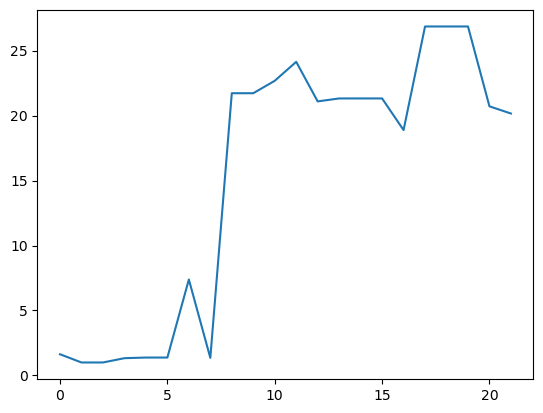

In [15]:
numericalize_genome = False
pde_uncertainties = []

for bs in pareto_optimal_models:
    numerical_genome = problem.numericalize_genome(bs[0])
    if numericalize_genome:
        numerical_genome = normalize_lp(numerical_genome)[0]
    
    # um = BayesianLinearRegression() # seems to work well with numericalize_genome = True
    um = ARDRegression(fit_intercept=False, compute_score=True, max_iter=1000)
    um.fit(numerical_genome, y_pre.ravel())
    
    pde_uncertainty = np.linalg.norm(np.sqrt(np.diag(um.sigma_)), 1)/np.linalg.norm(um.coef_, 1)
    pde_uncertainties.append(pde_uncertainty)

pde_uncertainties = np.array(pde_uncertainties)/min(pde_uncertainties)
print(pde_uncertainties)
del numerical_genome

plt.plot(pde_uncertainties); plt.show()

### MCDM/MCDA ###

In [22]:
from collections import Counter
from pymcdm import weights as obj_w
from compromise_programming import mcdm
from bayesian_model_evidence import log_evidence

include_uncertainty = False
types = np.array([-1, -1])
assert len(pareto_optimal_models) > 2
F = problem.evaluate(pareto_optimal_models)
# 2 criteria: acc, complexity / 3 criteria: acc, complexity, uncertainty
if include_uncertainty:
    F = np.hstack((F, pde_uncertainties.reshape(-1, 1)))
    types = np.array([-1, -1, -1])

# BIC or -log_evidence
ic = np.array([sm.OLS(y_pre, problem.numericalize_genome(bs[0])).fit().bic for bs in pareto_optimal_models])
# ic = np.array([-log_evidence(problem.numericalize_genome(bs[0]), y_pre) for bs in pareto_optimal_models])
max_ss = np.argmin(ic)+1
F = F[:max_ss]

obj_weights = obj_w.gini_weights(F, types=types)
print("Weights:", obj_weights)

# recursive mcdm
filtered_F = F.copy()
filtered_F[:, 0:1] = ic[:max_ss].reshape(-1, 1)
while len(filtered_F) > 2:
    ranks, prefs = mcdm(filtered_F, obj_weights, types)
    most_common = Counter(np.argmin(ranks, axis=1)).most_common()
    most_common = sorted(most_common, key=lambda _: (_[1], _[0]), reverse=True)
    print(filtered_F, most_common)

    # keep_until = max(most_common, key=lambda _: _[0])[0]
    keep_until = most_common[0][0]
    filtered_F = filtered_F[:keep_until+1]
    if len(most_common) == 1:
        break

Weights: [0.32925721 0.67074279]
[[-8.00921501e+04  1.00000000e+00]
 [-9.07065764e+04  2.00000000e+00]
 [-9.21029101e+04  3.00000000e+00]
 [-9.25365912e+04  4.00000000e+00]
 [-9.33260930e+04  5.00000000e+00]
 [-9.34123352e+04  6.00000000e+00]
 [-9.34847255e+04  7.00000000e+00]
 [-9.36136153e+04  8.00000000e+00]
 [-9.37059229e+04  9.00000000e+00]
 [-9.39015167e+04  1.00000000e+01]
 [-9.39594941e+04  1.10000000e+01]
 [-9.40871213e+04  1.20000000e+01]
 [-9.41400327e+04  1.30000000e+01]
 [-9.43827182e+04  1.40000000e+01]
 [-9.44498464e+04  1.50000000e+01]
 [-9.45136763e+04  1.60000000e+01]
 [-9.45552298e+04  1.70000000e+01]
 [-9.45638413e+04  1.80000000e+01]
 [-9.45630669e+04  1.90000000e+01]
 [-9.45625213e+04  2.00000000e+01]
 [-9.45912722e+04  2.10000000e+01]
 [-9.46177617e+04  2.20000000e+01]] [(1, 3), (2, 1)]


### Evaluate PDE coefficients

In [23]:
brute_force_all_subsets(X_pre, y_pre, max_support_size=2)

100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.63it/s]


(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.33694349,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.0929737 ,  0.        ,
          0.        ,  0.        ,  0.        , -0.97441351,  0.        ,
          0.        ,  0.        ,  0.        ,  0